<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:17] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


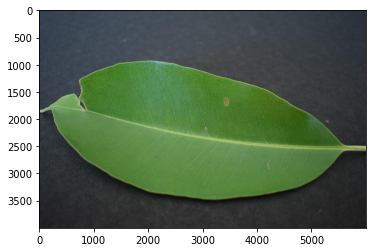

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

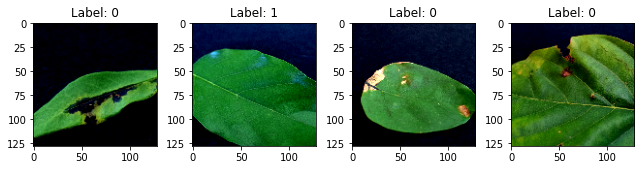

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:23] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:25] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.292180242073685 samples/sec                   batch loss = 1.3216816186904907 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2919979404692101 samples/sec                   batch loss = 1.750828742980957 | accuracy = 0.5


Epoch[1] Batch[15] Speed: 1.285566682635472 samples/sec                   batch loss = 0.4396325945854187 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.245844219571109 samples/sec                   batch loss = 1.6920984983444214 | accuracy = 0.575


Epoch[1] Batch[25] Speed: 1.2890305504067305 samples/sec                   batch loss = 0.29541438817977905 | accuracy = 0.6


Epoch[1] Batch[30] Speed: 1.283776441058188 samples/sec                   batch loss = 0.47265714406967163 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.281657710507678 samples/sec                   batch loss = 0.397783100605011 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.293281014852922 samples/sec                   batch loss = 0.5869499444961548 | accuracy = 0.6


Epoch[1] Batch[45] Speed: 1.2907980448319771 samples/sec                   batch loss = 0.5050708055496216 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2929600821343146 samples/sec                   batch loss = 0.5432907342910767 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2923840986651725 samples/sec                   batch loss = 0.6646020412445068 | accuracy = 0.5909090909090909


Epoch[1] Batch[60] Speed: 1.2965387027701074 samples/sec                   batch loss = 0.607048511505127 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2949176545010912 samples/sec                   batch loss = 0.8347470164299011 | accuracy = 0.6


Epoch[1] Batch[70] Speed: 1.2886951923692898 samples/sec                   batch loss = 0.35755056142807007 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.2904950192702571 samples/sec                   batch loss = 0.37706178426742554 | accuracy = 0.6233333333333333


Epoch[1] Batch[80] Speed: 1.288933598456219 samples/sec                   batch loss = 0.957636296749115 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2947713504290548 samples/sec                   batch loss = 0.7064934372901917 | accuracy = 0.6264705882352941


Epoch[1] Batch[90] Speed: 1.285011733996728 samples/sec                   batch loss = 0.6779531240463257 | accuracy = 0.6222222222222222


Epoch[1] Batch[95] Speed: 1.290062074739438 samples/sec                   batch loss = 0.7159987688064575 | accuracy = 0.618421052631579


Epoch[1] Batch[100] Speed: 1.2956881948778924 samples/sec                   batch loss = 0.5279296040534973 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.2873474033009442 samples/sec                   batch loss = 0.4327210783958435 | accuracy = 0.6238095238095238


Epoch[1] Batch[110] Speed: 1.2929461321510032 samples/sec                   batch loss = 0.5965529084205627 | accuracy = 0.6318181818181818


Epoch[1] Batch[115] Speed: 1.2982994330411675 samples/sec                   batch loss = 0.6596991419792175 | accuracy = 0.6304347826086957


Epoch[1] Batch[120] Speed: 1.2969416165016903 samples/sec                   batch loss = 0.519052267074585 | accuracy = 0.63125


Epoch[1] Batch[125] Speed: 1.2973691591397618 samples/sec                   batch loss = 0.8554878234863281 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.2979653608551778 samples/sec                   batch loss = 0.34169426560401917 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2982322231064254 samples/sec                   batch loss = 0.9156535267829895 | accuracy = 0.6370370370370371


Epoch[1] Batch[140] Speed: 1.2952432597186772 samples/sec                   batch loss = 0.49465835094451904 | accuracy = 0.6410714285714286


Epoch[1] Batch[145] Speed: 1.2895558695174116 samples/sec                   batch loss = 0.3315446078777313 | accuracy = 0.6448275862068965


Epoch[1] Batch[150] Speed: 1.2924169526684288 samples/sec                   batch loss = 0.7509384155273438 | accuracy = 0.645


Epoch[1] Batch[155] Speed: 1.2987628585698976 samples/sec                   batch loss = 1.1774619817733765 | accuracy = 0.646774193548387


Epoch[1] Batch[160] Speed: 1.2953176610432728 samples/sec                   batch loss = 1.4686390161514282 | accuracy = 0.653125


Epoch[1] Batch[165] Speed: 1.2846501331763116 samples/sec                   batch loss = 0.14202415943145752 | accuracy = 0.6606060606060606


Epoch[1] Batch[170] Speed: 1.2698192220620095 samples/sec                   batch loss = 0.6593930125236511 | accuracy = 0.6544117647058824


Epoch[1] Batch[175] Speed: 1.2641643812990775 samples/sec                   batch loss = 1.3917545080184937 | accuracy = 0.6514285714285715


Epoch[1] Batch[180] Speed: 1.2625444597760938 samples/sec                   batch loss = 0.4927184283733368 | accuracy = 0.6527777777777778


Epoch[1] Batch[185] Speed: 1.273572477767614 samples/sec                   batch loss = 0.8632999062538147 | accuracy = 0.6554054054054054


Epoch[1] Batch[190] Speed: 1.2651874839374462 samples/sec                   batch loss = 0.8565773367881775 | accuracy = 0.656578947368421


Epoch[1] Batch[195] Speed: 1.2629272797512388 samples/sec                   batch loss = 0.31135421991348267 | accuracy = 0.6602564102564102


Epoch[1] Batch[200] Speed: 1.2632980607867677 samples/sec                   batch loss = 0.47187209129333496 | accuracy = 0.6625


Epoch[1] Batch[205] Speed: 1.263217305364866 samples/sec                   batch loss = 0.39212340116500854 | accuracy = 0.6646341463414634


Epoch[1] Batch[210] Speed: 1.2609980584322307 samples/sec                   batch loss = 0.1538478136062622 | accuracy = 0.669047619047619


Epoch[1] Batch[215] Speed: 1.2582246084625972 samples/sec                   batch loss = 0.40175068378448486 | accuracy = 0.6697674418604651


Epoch[1] Batch[220] Speed: 1.2677046039216504 samples/sec                   batch loss = 0.3550536334514618 | accuracy = 0.6727272727272727


Epoch[1] Batch[225] Speed: 1.2604300237072288 samples/sec                   batch loss = 1.2395273447036743 | accuracy = 0.6733333333333333


Epoch[1] Batch[230] Speed: 1.273797487104836 samples/sec                   batch loss = 0.1437394767999649 | accuracy = 0.6760869565217391


Epoch[1] Batch[235] Speed: 1.2634481848699792 samples/sec                   batch loss = 0.2810420095920563 | accuracy = 0.676595744680851


Epoch[1] Batch[240] Speed: 1.261534257654509 samples/sec                   batch loss = 0.5328423976898193 | accuracy = 0.6760416666666667


Epoch[1] Batch[245] Speed: 1.2604713111798167 samples/sec                   batch loss = 0.2547847330570221 | accuracy = 0.6775510204081633


Epoch[1] Batch[250] Speed: 1.269100733772388 samples/sec                   batch loss = 0.381163626909256 | accuracy = 0.679


Epoch[1] Batch[255] Speed: 1.2598691230832055 samples/sec                   batch loss = 0.5155705809593201 | accuracy = 0.6774509803921569


Epoch[1] Batch[260] Speed: 1.2639403815352719 samples/sec                   batch loss = 0.307589054107666 | accuracy = 0.6759615384615385


Epoch[1] Batch[265] Speed: 1.2699008238164535 samples/sec                   batch loss = 0.4651656746864319 | accuracy = 0.6754716981132075


Epoch[1] Batch[270] Speed: 1.2676520178694548 samples/sec                   batch loss = 0.42687398195266724 | accuracy = 0.6796296296296296


Epoch[1] Batch[275] Speed: 1.2674233336604401 samples/sec                   batch loss = 0.7856221199035645 | accuracy = 0.68


Epoch[1] Batch[280] Speed: 1.258564874932054 samples/sec                   batch loss = 0.49437785148620605 | accuracy = 0.6794642857142857


Epoch[1] Batch[285] Speed: 1.2584480970164955 samples/sec                   batch loss = 1.251922369003296 | accuracy = 0.6807017543859649


Epoch[1] Batch[290] Speed: 1.2591391672721994 samples/sec                   batch loss = 0.4777582287788391 | accuracy = 0.6801724137931034


Epoch[1] Batch[295] Speed: 1.2628545565113176 samples/sec                   batch loss = 0.25300607085227966 | accuracy = 0.6813559322033899


Epoch[1] Batch[300] Speed: 1.2650072817849063 samples/sec                   batch loss = 0.5441078543663025 | accuracy = 0.6833333333333333


Epoch[1] Batch[305] Speed: 1.2593022938117013 samples/sec                   batch loss = 0.85098797082901 | accuracy = 0.6819672131147541


Epoch[1] Batch[310] Speed: 1.2644413478830019 samples/sec                   batch loss = 0.4539456069469452 | accuracy = 0.6814516129032258


Epoch[1] Batch[315] Speed: 1.2622952003755914 samples/sec                   batch loss = 0.7803856730461121 | accuracy = 0.6801587301587302


Epoch[1] Batch[320] Speed: 1.264684019633746 samples/sec                   batch loss = 0.5768221616744995 | accuracy = 0.6796875


Epoch[1] Batch[325] Speed: 1.2622423973765078 samples/sec                   batch loss = 0.3301900625228882 | accuracy = 0.6823076923076923


Epoch[1] Batch[330] Speed: 1.261994491284813 samples/sec                   batch loss = 0.5933523178100586 | accuracy = 0.6825757575757576


Epoch[1] Batch[335] Speed: 1.2688456164432773 samples/sec                   batch loss = 0.5188359618186951 | accuracy = 0.6813432835820895


Epoch[1] Batch[340] Speed: 1.2666974157274273 samples/sec                   batch loss = 3.3039822578430176 | accuracy = 0.6772058823529412


Epoch[1] Batch[345] Speed: 1.265054402218782 samples/sec                   batch loss = 0.7063227891921997 | accuracy = 0.6789855072463769


Epoch[1] Batch[350] Speed: 1.2641078976830964 samples/sec                   batch loss = 0.3210495412349701 | accuracy = 0.6785714285714286


Epoch[1] Batch[355] Speed: 1.2700205061349217 samples/sec                   batch loss = 1.125321626663208 | accuracy = 0.676056338028169


Epoch[1] Batch[360] Speed: 1.273117577196699 samples/sec                   batch loss = 0.3923848569393158 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.2699299492435736 samples/sec                   batch loss = 0.8020395636558533 | accuracy = 0.673972602739726


Epoch[1] Batch[370] Speed: 1.2677911074103805 samples/sec                   batch loss = 0.41885101795196533 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2647249188986835 samples/sec                   batch loss = 0.658271074295044 | accuracy = 0.6746666666666666


Epoch[1] Batch[380] Speed: 1.2644960505074387 samples/sec                   batch loss = 1.1277976036071777 | accuracy = 0.6756578947368421


Epoch[1] Batch[385] Speed: 1.2571073191821602 samples/sec                   batch loss = 0.5126071572303772 | accuracy = 0.6766233766233766


Epoch[1] Batch[390] Speed: 1.2488600586093936 samples/sec                   batch loss = 0.26621049642562866 | accuracy = 0.6794871794871795


Epoch[1] Batch[395] Speed: 1.2616034136020708 samples/sec                   batch loss = 0.5830065608024597 | accuracy = 0.6797468354430379


Epoch[1] Batch[400] Speed: 1.2600049011659533 samples/sec                   batch loss = 0.8568513989448547 | accuracy = 0.6775


Epoch[1] Batch[405] Speed: 1.2617069245287573 samples/sec                   batch loss = 0.2148236334323883 | accuracy = 0.6777777777777778


Epoch[1] Batch[410] Speed: 1.2678719696288985 samples/sec                   batch loss = 0.775254487991333 | accuracy = 0.6792682926829269


Epoch[1] Batch[415] Speed: 1.2664904911016543 samples/sec                   batch loss = 0.5793105959892273 | accuracy = 0.6813253012048193


Epoch[1] Batch[420] Speed: 1.272419670867941 samples/sec                   batch loss = 0.6884494423866272 | accuracy = 0.6803571428571429


Epoch[1] Batch[425] Speed: 1.2621599727484687 samples/sec                   batch loss = 0.37326952815055847 | accuracy = 0.68


Epoch[1] Batch[430] Speed: 1.2724675381608306 samples/sec                   batch loss = 0.7576702833175659 | accuracy = 0.6796511627906977


Epoch[1] Batch[435] Speed: 1.2646285381460711 samples/sec                   batch loss = 0.7622911930084229 | accuracy = 0.6810344827586207


Epoch[1] Batch[440] Speed: 1.260332213494839 samples/sec                   batch loss = 1.4269022941589355 | accuracy = 0.6801136363636363


Epoch[1] Batch[445] Speed: 1.268088067986846 samples/sec                   batch loss = 0.719272255897522 | accuracy = 0.6792134831460674


Epoch[1] Batch[450] Speed: 1.2661513727607459 samples/sec                   batch loss = 0.9754189848899841 | accuracy = 0.6805555555555556


Epoch[1] Batch[455] Speed: 1.2650968517689336 samples/sec                   batch loss = 0.8620651960372925 | accuracy = 0.6818681318681319


Epoch[1] Batch[460] Speed: 1.2649457634249377 samples/sec                   batch loss = 0.19621175527572632 | accuracy = 0.683695652173913


Epoch[1] Batch[465] Speed: 1.2581942246801328 samples/sec                   batch loss = 0.5996405482292175 | accuracy = 0.6849462365591398


Epoch[1] Batch[470] Speed: 1.2624848907479642 samples/sec                   batch loss = 1.3379194736480713 | accuracy = 0.6856382978723404


Epoch[1] Batch[475] Speed: 1.2598359163128892 samples/sec                   batch loss = 0.7033970355987549 | accuracy = 0.6852631578947368


Epoch[1] Batch[480] Speed: 1.2622680385689133 samples/sec                   batch loss = 0.7976941466331482 | accuracy = 0.6833333333333333


Epoch[1] Batch[485] Speed: 1.2681637917102748 samples/sec                   batch loss = 0.6166341304779053 | accuracy = 0.6829896907216495


Epoch[1] Batch[490] Speed: 1.2639261937477404 samples/sec                   batch loss = 0.5819526314735413 | accuracy = 0.6831632653061225


Epoch[1] Batch[495] Speed: 1.2675111394035785 samples/sec                   batch loss = 0.4791756570339203 | accuracy = 0.6838383838383838


Epoch[1] Batch[500] Speed: 1.2638688745203113 samples/sec                   batch loss = 1.2018393278121948 | accuracy = 0.685


Epoch[1] Batch[505] Speed: 1.2656615585957094 samples/sec                   batch loss = 0.4860648512840271 | accuracy = 0.6846534653465347


Epoch[1] Batch[510] Speed: 1.2690046448133725 samples/sec                   batch loss = 0.6712762117385864 | accuracy = 0.6848039215686275


Epoch[1] Batch[515] Speed: 1.2636987565340225 samples/sec                   batch loss = 0.5656260848045349 | accuracy = 0.6844660194174758


Epoch[1] Batch[520] Speed: 1.2660027073410234 samples/sec                   batch loss = 0.1884055733680725 | accuracy = 0.6850961538461539


Epoch[1] Batch[525] Speed: 1.2590670686043508 samples/sec                   batch loss = 0.34217527508735657 | accuracy = 0.6871428571428572


Epoch[1] Batch[530] Speed: 1.2608546751614376 samples/sec                   batch loss = 1.3352458477020264 | accuracy = 0.6867924528301886


Epoch[1] Batch[535] Speed: 1.2662732165340833 samples/sec                   batch loss = 0.42102348804473877 | accuracy = 0.6855140186915888


Epoch[1] Batch[540] Speed: 1.258225835167863 samples/sec                   batch loss = 0.6073341965675354 | accuracy = 0.687037037037037


Epoch[1] Batch[545] Speed: 1.2608701207013766 samples/sec                   batch loss = 0.3223930895328522 | accuracy = 0.6894495412844037


Epoch[1] Batch[550] Speed: 1.2659354563077552 samples/sec                   batch loss = 0.4846879541873932 | accuracy = 0.6890909090909091


Epoch[1] Batch[555] Speed: 1.2668367741436635 samples/sec                   batch loss = 0.6490229368209839 | accuracy = 0.6896396396396396


Epoch[1] Batch[560] Speed: 1.2604087181567212 samples/sec                   batch loss = 0.27086058259010315 | accuracy = 0.6919642857142857


Epoch[1] Batch[565] Speed: 1.259581389216975 samples/sec                   batch loss = 0.6825278401374817 | accuracy = 0.6911504424778762


Epoch[1] Batch[570] Speed: 1.2639231467476717 samples/sec                   batch loss = 0.4650307893753052 | accuracy = 0.6921052631578948


Epoch[1] Batch[575] Speed: 1.2648673719535235 samples/sec                   batch loss = 0.19712747633457184 | accuracy = 0.6926086956521739


Epoch[1] Batch[580] Speed: 1.269417997841026 samples/sec                   batch loss = 0.4491296708583832 | accuracy = 0.6922413793103448


Epoch[1] Batch[585] Speed: 1.275071782189505 samples/sec                   batch loss = 0.24254851043224335 | accuracy = 0.6931623931623931


Epoch[1] Batch[590] Speed: 1.268567676461866 samples/sec                   batch loss = 0.8151910901069641 | accuracy = 0.6936440677966101


Epoch[1] Batch[595] Speed: 1.2661113366709482 samples/sec                   batch loss = 0.2946583330631256 | accuracy = 0.6941176470588235


Epoch[1] Batch[600] Speed: 1.2648976974287858 samples/sec                   batch loss = 0.36799973249435425 | accuracy = 0.6945833333333333


Epoch[1] Batch[605] Speed: 1.2693004456831214 samples/sec                   batch loss = 0.3696877062320709 | accuracy = 0.6954545454545454


Epoch[1] Batch[610] Speed: 1.266606471485301 samples/sec                   batch loss = 0.41457733511924744 | accuracy = 0.6959016393442623


Epoch[1] Batch[615] Speed: 1.2773400119304168 samples/sec                   batch loss = 0.250192791223526 | accuracy = 0.6967479674796748


Epoch[1] Batch[620] Speed: 1.2654917213452825 samples/sec                   batch loss = 0.4002946615219116 | accuracy = 0.6967741935483871


Epoch[1] Batch[625] Speed: 1.2584026944787308 samples/sec                   batch loss = 0.3390714228153229 | accuracy = 0.6964


Epoch[1] Batch[630] Speed: 1.2645018641307715 samples/sec                   batch loss = 0.3128003776073456 | accuracy = 0.6968253968253968


Epoch[1] Batch[635] Speed: 1.2591075108769894 samples/sec                   batch loss = 0.39733079075813293 | accuracy = 0.6964566929133859


Epoch[1] Batch[640] Speed: 1.2633329723928741 samples/sec                   batch loss = 0.2854979336261749 | accuracy = 0.696484375


Epoch[1] Batch[645] Speed: 1.26084699991117 samples/sec                   batch loss = 0.23355531692504883 | accuracy = 0.6972868217054263


Epoch[1] Batch[650] Speed: 1.2706087672769555 samples/sec                   batch loss = 0.6161400675773621 | accuracy = 0.696923076923077


Epoch[1] Batch[655] Speed: 1.2650616518278763 samples/sec                   batch loss = 0.23763883113861084 | accuracy = 0.6965648854961832


Epoch[1] Batch[660] Speed: 1.263720649398074 samples/sec                   batch loss = 0.49029111862182617 | accuracy = 0.6981060606060606


Epoch[1] Batch[665] Speed: 1.2698649715773258 samples/sec                   batch loss = 0.49703294038772583 | accuracy = 0.6988721804511279


Epoch[1] Batch[670] Speed: 1.2613626811968484 samples/sec                   batch loss = 1.2487026453018188 | accuracy = 0.6996268656716418


Epoch[1] Batch[675] Speed: 1.2579483776183895 samples/sec                   batch loss = 1.2800182104110718 | accuracy = 0.6981481481481482


Epoch[1] Batch[680] Speed: 1.2576807532044134 samples/sec                   batch loss = 0.5210169553756714 | accuracy = 0.6977941176470588


Epoch[1] Batch[685] Speed: 1.2593610902141914 samples/sec                   batch loss = 0.21478389203548431 | accuracy = 0.6974452554744526


Epoch[1] Batch[690] Speed: 1.2668763778056567 samples/sec                   batch loss = 0.4745889902114868 | accuracy = 0.6985507246376812


Epoch[1] Batch[695] Speed: 1.2686965095755218 samples/sec                   batch loss = 0.7676181793212891 | accuracy = 0.6985611510791367


Epoch[1] Batch[700] Speed: 1.2645478031657231 samples/sec                   batch loss = 0.6226386427879333 | accuracy = 0.7


Epoch[1] Batch[705] Speed: 1.253511404326378 samples/sec                   batch loss = 0.3293085992336273 | accuracy = 0.700709219858156


Epoch[1] Batch[710] Speed: 1.2671304166824329 samples/sec                   batch loss = 0.25111567974090576 | accuracy = 0.7014084507042253


Epoch[1] Batch[715] Speed: 1.2569183937303676 samples/sec                   batch loss = 0.3938923180103302 | accuracy = 0.7013986013986014


Epoch[1] Batch[720] Speed: 1.263399090939692 samples/sec                   batch loss = 0.5382741093635559 | accuracy = 0.7024305555555556


Epoch[1] Batch[725] Speed: 1.2578256787163071 samples/sec                   batch loss = 0.7737248539924622 | accuracy = 0.7024137931034483


Epoch[1] Batch[730] Speed: 1.2581169508023138 samples/sec                   batch loss = 0.4115292727947235 | accuracy = 0.7013698630136986


Epoch[1] Batch[735] Speed: 1.2645834511068448 samples/sec                   batch loss = 0.3031764626502991 | accuracy = 0.7017006802721089


Epoch[1] Batch[740] Speed: 1.2607951707289469 samples/sec                   batch loss = 0.5516263246536255 | accuracy = 0.702027027027027


Epoch[1] Batch[745] Speed: 1.2549150080352571 samples/sec                   batch loss = 0.4359690546989441 | accuracy = 0.7023489932885906


Epoch[1] Batch[750] Speed: 1.2563760431785806 samples/sec                   batch loss = 0.5561915636062622 | accuracy = 0.7023333333333334


Epoch[1] Batch[755] Speed: 1.2559311797201878 samples/sec                   batch loss = 0.48628342151641846 | accuracy = 0.702317880794702


Epoch[1] Batch[760] Speed: 1.254661902248461 samples/sec                   batch loss = 0.38395798206329346 | accuracy = 0.7019736842105263


Epoch[1] Batch[765] Speed: 1.2556307695255293 samples/sec                   batch loss = 0.6835189461708069 | accuracy = 0.7016339869281045


Epoch[1] Batch[770] Speed: 1.257549811508625 samples/sec                   batch loss = 0.5265355706214905 | accuracy = 0.7012987012987013


Epoch[1] Batch[775] Speed: 1.2648912126137366 samples/sec                   batch loss = 0.6710051894187927 | accuracy = 0.7016129032258065


Epoch[1] Batch[780] Speed: 1.2613923646633338 samples/sec                   batch loss = 0.5365261435508728 | accuracy = 0.7019230769230769


Epoch[1] Batch[785] Speed: 1.2665694663679443 samples/sec                   batch loss = 0.6994428038597107 | accuracy = 0.7015923566878981


[Epoch 1] training: accuracy=0.7014593908629442
[Epoch 1] time cost: 649.3090724945068
[Epoch 1] validation: validation accuracy=0.7544444444444445


Epoch[2] Batch[5] Speed: 1.2689644280804742 samples/sec                   batch loss = 0.4678001403808594 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2630956685719388 samples/sec                   batch loss = 0.5547091364860535 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2678861503226428 samples/sec                   batch loss = 0.30898645520210266 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2621523765503428 samples/sec                   batch loss = 0.2477005571126938 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.263751776645502 samples/sec                   batch loss = 0.1557827889919281 | accuracy = 0.79


Epoch[2] Batch[30] Speed: 1.265038567835227 samples/sec                   batch loss = 0.25935283303260803 | accuracy = 0.8083333333333333


Epoch[2] Batch[35] Speed: 1.2579735616756769 samples/sec                   batch loss = 0.654486358165741 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.2617273251108405 samples/sec                   batch loss = 0.5496577024459839 | accuracy = 0.79375


Epoch[2] Batch[45] Speed: 1.261045923293286 samples/sec                   batch loss = 0.33316195011138916 | accuracy = 0.8


Epoch[2] Batch[50] Speed: 1.26119361639926 samples/sec                   batch loss = 0.484706848859787 | accuracy = 0.785


Epoch[2] Batch[55] Speed: 1.2573627319246785 samples/sec                   batch loss = 0.3860630989074707 | accuracy = 0.7863636363636364


Epoch[2] Batch[60] Speed: 1.2617241938158488 samples/sec                   batch loss = 0.48401984572410583 | accuracy = 0.7791666666666667


Epoch[2] Batch[65] Speed: 1.260759262331941 samples/sec                   batch loss = 0.21025852859020233 | accuracy = 0.7692307692307693


Epoch[2] Batch[70] Speed: 1.2596352938402924 samples/sec                   batch loss = 0.38282960653305054 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.261914282095324 samples/sec                   batch loss = 0.314346581697464 | accuracy = 0.7533333333333333


Epoch[2] Batch[80] Speed: 1.2585313592466283 samples/sec                   batch loss = 0.1872711330652237 | accuracy = 0.746875


Epoch[2] Batch[85] Speed: 1.2634029916744645 samples/sec                   batch loss = 0.5161293148994446 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.265629573392444 samples/sec                   batch loss = 0.666205644607544 | accuracy = 0.7444444444444445


Epoch[2] Batch[95] Speed: 1.2616057853396783 samples/sec                   batch loss = 0.5416611433029175 | accuracy = 0.7447368421052631


Epoch[2] Batch[100] Speed: 1.2655809780732263 samples/sec                   batch loss = 0.3450924754142761 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.2585475031990265 samples/sec                   batch loss = 0.2945142686367035 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2631573875196809 samples/sec                   batch loss = 0.23126645386219025 | accuracy = 0.75


Epoch[2] Batch[115] Speed: 1.271291779340778 samples/sec                   batch loss = 0.5302326083183289 | accuracy = 0.7434782608695653


Epoch[2] Batch[120] Speed: 1.2658811066451678 samples/sec                   batch loss = 0.5785114765167236 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.2666145995138804 samples/sec                   batch loss = 0.37164315581321716 | accuracy = 0.744


Epoch[2] Batch[130] Speed: 1.2622582568059462 samples/sec                   batch loss = 0.5431239008903503 | accuracy = 0.7442307692307693


Epoch[2] Batch[135] Speed: 1.2643266211669681 samples/sec                   batch loss = 0.6048166751861572 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.2669235419183031 samples/sec                   batch loss = 0.2702901363372803 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.2715276438313285 samples/sec                   batch loss = 0.4382948577404022 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.2658314414387906 samples/sec                   batch loss = 0.5708223581314087 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.263492334608106 samples/sec                   batch loss = 0.36896249651908875 | accuracy = 0.7435483870967742


Epoch[2] Batch[160] Speed: 1.2622935858299307 samples/sec                   batch loss = 0.3571788966655731 | accuracy = 0.746875


Epoch[2] Batch[165] Speed: 1.264594698735316 samples/sec                   batch loss = 0.2767491638660431 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.266530455562354 samples/sec                   batch loss = 0.38199204206466675 | accuracy = 0.7426470588235294


Epoch[2] Batch[175] Speed: 1.29072346669227 samples/sec                   batch loss = 0.3117596209049225 | accuracy = 0.7414285714285714


Epoch[2] Batch[180] Speed: 1.2922382669672736 samples/sec                   batch loss = 0.9137335419654846 | accuracy = 0.7388888888888889


Epoch[2] Batch[185] Speed: 1.291349455507361 samples/sec                   batch loss = 0.5059424638748169 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2941084997698296 samples/sec                   batch loss = 1.0392827987670898 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.299873570579739 samples/sec                   batch loss = 0.3328488767147064 | accuracy = 0.7423076923076923


Epoch[2] Batch[200] Speed: 1.2846883007422947 samples/sec                   batch loss = 0.40468674898147583 | accuracy = 0.74125


Epoch[2] Batch[205] Speed: 1.2848779917715871 samples/sec                   batch loss = 0.306021511554718 | accuracy = 0.7463414634146341


Epoch[2] Batch[210] Speed: 1.2904106501926131 samples/sec                   batch loss = 0.6992307901382446 | accuracy = 0.7488095238095238


Epoch[2] Batch[215] Speed: 1.2942094265708566 samples/sec                   batch loss = 0.5390931963920593 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2936717311498371 samples/sec                   batch loss = 0.4663257896900177 | accuracy = 0.7477272727272727


Epoch[2] Batch[225] Speed: 1.2945018137992255 samples/sec                   batch loss = 0.8602519035339355 | accuracy = 0.7477777777777778


Epoch[2] Batch[230] Speed: 1.2840997101264695 samples/sec                   batch loss = 0.13283522427082062 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.2825957808134183 samples/sec                   batch loss = 0.42297160625457764 | accuracy = 0.7468085106382979


Epoch[2] Batch[240] Speed: 1.2812967224902216 samples/sec                   batch loss = 0.5057337284088135 | accuracy = 0.7489583333333333


Epoch[2] Batch[245] Speed: 1.292872003004153 samples/sec                   batch loss = 0.25514984130859375 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2910017635332593 samples/sec                   batch loss = 0.7362855076789856 | accuracy = 0.748


Epoch[2] Batch[255] Speed: 1.2868440167547588 samples/sec                   batch loss = 0.5679829120635986 | accuracy = 0.75


Epoch[2] Batch[260] Speed: 1.2808849864530425 samples/sec                   batch loss = 0.2838456928730011 | accuracy = 0.7519230769230769


Epoch[2] Batch[265] Speed: 1.2834945732754885 samples/sec                   batch loss = 0.43065330386161804 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.294005892020351 samples/sec                   batch loss = 0.44755956530570984 | accuracy = 0.7518518518518519


Epoch[2] Batch[275] Speed: 1.2924202381606256 samples/sec                   batch loss = 0.4050229787826538 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.287882225964882 samples/sec                   batch loss = 0.487979531288147 | accuracy = 0.7473214285714286


Epoch[2] Batch[285] Speed: 1.2873827677245164 samples/sec                   batch loss = 0.5394731760025024 | accuracy = 0.7482456140350877


Epoch[2] Batch[290] Speed: 1.286663908341811 samples/sec                   batch loss = 0.4370165467262268 | accuracy = 0.7482758620689656


Epoch[2] Batch[295] Speed: 1.2861364068968282 samples/sec                   batch loss = 0.5710384249687195 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.2833084316416628 samples/sec                   batch loss = 0.323993057012558 | accuracy = 0.7483333333333333


Epoch[2] Batch[305] Speed: 1.2947456706799638 samples/sec                   batch loss = 0.2148522138595581 | accuracy = 0.75


Epoch[2] Batch[310] Speed: 1.2851470791565187 samples/sec                   batch loss = 0.576262891292572 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.291398658261997 samples/sec                   batch loss = 0.49501657485961914 | accuracy = 0.7476190476190476


Epoch[2] Batch[320] Speed: 1.2912024659748633 samples/sec                   batch loss = 0.17007851600646973 | accuracy = 0.74921875


Epoch[2] Batch[325] Speed: 1.2900910410993707 samples/sec                   batch loss = 0.3703894317150116 | accuracy = 0.75


Epoch[2] Batch[330] Speed: 1.290690897319041 samples/sec                   batch loss = 0.3600756824016571 | accuracy = 0.75


Epoch[2] Batch[335] Speed: 1.2903456438993364 samples/sec                   batch loss = 0.7688736319541931 | accuracy = 0.75


Epoch[2] Batch[340] Speed: 1.2913632716598635 samples/sec                   batch loss = 0.36508694291114807 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2923780258353648 samples/sec                   batch loss = 0.4529414474964142 | accuracy = 0.7492753623188406


Epoch[2] Batch[350] Speed: 1.2940054928001865 samples/sec                   batch loss = 0.8237491846084595 | accuracy = 0.7485714285714286


Epoch[2] Batch[355] Speed: 1.3009694373435845 samples/sec                   batch loss = 0.48172077536582947 | accuracy = 0.7485915492957746


Epoch[2] Batch[360] Speed: 1.2929106606921918 samples/sec                   batch loss = 0.3244597315788269 | accuracy = 0.7479166666666667


Epoch[2] Batch[365] Speed: 1.2964738790961907 samples/sec                   batch loss = 0.5856406688690186 | accuracy = 0.7479452054794521


Epoch[2] Batch[370] Speed: 1.2917968912114977 samples/sec                   batch loss = 0.3463289141654968 | accuracy = 0.7472972972972973


Epoch[2] Batch[375] Speed: 1.2896556908851105 samples/sec                   batch loss = 0.6210534572601318 | accuracy = 0.748


Epoch[2] Batch[380] Speed: 1.293645197254642 samples/sec                   batch loss = 0.12856298685073853 | accuracy = 0.7480263157894737


Epoch[2] Batch[385] Speed: 1.296514355560601 samples/sec                   batch loss = 0.5117821097373962 | accuracy = 0.7474025974025974


Epoch[2] Batch[390] Speed: 1.2976020542329885 samples/sec                   batch loss = 0.12307538837194443 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.2966100463611148 samples/sec                   batch loss = 0.6580417156219482 | accuracy = 0.7481012658227848


Epoch[2] Batch[400] Speed: 1.2935548305751807 samples/sec                   batch loss = 0.5712627172470093 | accuracy = 0.74875


Epoch[2] Batch[405] Speed: 1.2925783597725393 samples/sec                   batch loss = 0.40030789375305176 | accuracy = 0.7469135802469136


Epoch[2] Batch[410] Speed: 1.2904374485864174 samples/sec                   batch loss = 0.7819535732269287 | accuracy = 0.7469512195121951


Epoch[2] Batch[415] Speed: 1.2893511205190784 samples/sec                   batch loss = 0.5302100777626038 | accuracy = 0.7475903614457832


Epoch[2] Batch[420] Speed: 1.2850615377002956 samples/sec                   batch loss = 0.7728145718574524 | accuracy = 0.7452380952380953


Epoch[2] Batch[425] Speed: 1.2924780854714761 samples/sec                   batch loss = 0.5126020908355713 | accuracy = 0.7452941176470588


Epoch[2] Batch[430] Speed: 1.2948769778514595 samples/sec                   batch loss = 0.2762733995914459 | accuracy = 0.7459302325581395


Epoch[2] Batch[435] Speed: 1.2971807769824935 samples/sec                   batch loss = 0.4028834402561188 | accuracy = 0.7471264367816092


Epoch[2] Batch[440] Speed: 1.2946749317366215 samples/sec                   batch loss = 0.5761654376983643 | accuracy = 0.7482954545454545


Epoch[2] Batch[445] Speed: 1.2944020397853189 samples/sec                   batch loss = 0.4988843500614166 | accuracy = 0.748876404494382


Epoch[2] Batch[450] Speed: 1.304587419917466 samples/sec                   batch loss = 0.47068336606025696 | accuracy = 0.7483333333333333


Epoch[2] Batch[455] Speed: 1.2902969182858106 samples/sec                   batch loss = 0.417835533618927 | accuracy = 0.7494505494505495


Epoch[2] Batch[460] Speed: 1.2949008638298487 samples/sec                   batch loss = 0.6641870737075806 | accuracy = 0.75


Epoch[2] Batch[465] Speed: 1.3010288596388853 samples/sec                   batch loss = 0.45433473587036133 | accuracy = 0.75


Epoch[2] Batch[470] Speed: 1.2964856009806087 samples/sec                   batch loss = 0.4216500222682953 | accuracy = 0.7510638297872341


Epoch[2] Batch[475] Speed: 1.301301222417803 samples/sec                   batch loss = 0.5095477104187012 | accuracy = 0.751578947368421


Epoch[2] Batch[480] Speed: 1.297766064144416 samples/sec                   batch loss = 0.3489430546760559 | accuracy = 0.7520833333333333


Epoch[2] Batch[485] Speed: 1.2965356968922956 samples/sec                   batch loss = 0.5928251147270203 | accuracy = 0.7530927835051546


Epoch[2] Batch[490] Speed: 1.29750320659439 samples/sec                   batch loss = 0.8767527341842651 | accuracy = 0.7525510204081632


Epoch[2] Batch[495] Speed: 1.2915282931661427 samples/sec                   batch loss = 0.17230097949504852 | accuracy = 0.752020202020202


Epoch[2] Batch[500] Speed: 1.2936512819990862 samples/sec                   batch loss = 0.29016318917274475 | accuracy = 0.7535


Epoch[2] Batch[505] Speed: 1.298927866029978 samples/sec                   batch loss = 0.7936153411865234 | accuracy = 0.7524752475247525


Epoch[2] Batch[510] Speed: 1.299972074631709 samples/sec                   batch loss = 0.20961472392082214 | accuracy = 0.753921568627451


Epoch[2] Batch[515] Speed: 1.2960563375929521 samples/sec                   batch loss = 0.9186795353889465 | accuracy = 0.753883495145631


Epoch[2] Batch[520] Speed: 1.2945894158781581 samples/sec                   batch loss = 0.5622681379318237 | accuracy = 0.7543269230769231


Epoch[2] Batch[525] Speed: 1.2970196222619106 samples/sec                   batch loss = 0.47733625769615173 | accuracy = 0.7538095238095238


Epoch[2] Batch[530] Speed: 1.294984721584571 samples/sec                   batch loss = 0.3529073894023895 | accuracy = 0.7528301886792453


Epoch[2] Batch[535] Speed: 1.298586233429345 samples/sec                   batch loss = 0.24311436712741852 | accuracy = 0.7532710280373832


Epoch[2] Batch[540] Speed: 1.2982370451121699 samples/sec                   batch loss = 0.2771502733230591 | accuracy = 0.7523148148148148


Epoch[2] Batch[545] Speed: 1.2982068077097806 samples/sec                   batch loss = 0.5784633755683899 | accuracy = 0.751834862385321


Epoch[2] Batch[550] Speed: 1.2962651247978112 samples/sec                   batch loss = 0.6348798274993896 | accuracy = 0.7527272727272727


Epoch[2] Batch[555] Speed: 1.2992786335578046 samples/sec                   batch loss = 0.31934496760368347 | accuracy = 0.7522522522522522


Epoch[2] Batch[560] Speed: 1.290779672586107 samples/sec                   batch loss = 0.6263826489448547 | accuracy = 0.7522321428571429


Epoch[2] Batch[565] Speed: 1.2910173604471447 samples/sec                   batch loss = 0.4050833284854889 | accuracy = 0.7526548672566372


Epoch[2] Batch[570] Speed: 1.2947626571703708 samples/sec                   batch loss = 0.41118255257606506 | accuracy = 0.7530701754385964


Epoch[2] Batch[575] Speed: 1.2947181934773497 samples/sec                   batch loss = 0.5791594386100769 | accuracy = 0.7521739130434782


Epoch[2] Batch[580] Speed: 1.296436911464475 samples/sec                   batch loss = 0.19543904066085815 | accuracy = 0.7525862068965518


Epoch[2] Batch[585] Speed: 1.2966707747602808 samples/sec                   batch loss = 0.3210340142250061 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2950981817216194 samples/sec                   batch loss = 0.558407187461853 | accuracy = 0.7538135593220339


Epoch[2] Batch[595] Speed: 1.2918548816809527 samples/sec                   batch loss = 1.0582029819488525 | accuracy = 0.7546218487394958


Epoch[2] Batch[600] Speed: 1.29618801089813 samples/sec                   batch loss = 0.512317419052124 | accuracy = 0.75375


Epoch[2] Batch[605] Speed: 1.2877263383811424 samples/sec                   batch loss = 0.8624323606491089 | accuracy = 0.753305785123967


Epoch[2] Batch[610] Speed: 1.295938805471407 samples/sec                   batch loss = 0.4283623993396759 | accuracy = 0.7532786885245901


Epoch[2] Batch[615] Speed: 1.2987215378547645 samples/sec                   batch loss = 0.4851280748844147 | accuracy = 0.7532520325203252


Epoch[2] Batch[620] Speed: 1.3011765813566916 samples/sec                   batch loss = 0.28579461574554443 | accuracy = 0.7548387096774194


Epoch[2] Batch[625] Speed: 1.300346385123119 samples/sec                   batch loss = 0.3595201075077057 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.289389270654825 samples/sec                   batch loss = 1.1936787366867065 | accuracy = 0.753968253968254


Epoch[2] Batch[635] Speed: 1.2911053857648094 samples/sec                   batch loss = 0.3897353708744049 | accuracy = 0.7543307086614173


Epoch[2] Batch[640] Speed: 1.292088189255328 samples/sec                   batch loss = 0.28126659989356995 | accuracy = 0.754296875


Epoch[2] Batch[645] Speed: 1.2909669946995395 samples/sec                   batch loss = 1.6044366359710693 | accuracy = 0.7538759689922481


Epoch[2] Batch[650] Speed: 1.2935393717567483 samples/sec                   batch loss = 0.4701184630393982 | accuracy = 0.7546153846153846


Epoch[2] Batch[655] Speed: 1.2932544969827404 samples/sec                   batch loss = 0.8018131852149963 | accuracy = 0.7549618320610687


Epoch[2] Batch[660] Speed: 1.295722417925765 samples/sec                   batch loss = 0.4767187535762787 | accuracy = 0.7553030303030303


Epoch[2] Batch[665] Speed: 1.294421014639569 samples/sec                   batch loss = 0.4913407266139984 | accuracy = 0.7552631578947369


Epoch[2] Batch[670] Speed: 1.289469442842161 samples/sec                   batch loss = 0.3209501802921295 | accuracy = 0.7567164179104477


Epoch[2] Batch[675] Speed: 1.289903278873929 samples/sec                   batch loss = 0.5250555872917175 | accuracy = 0.7551851851851852


Epoch[2] Batch[680] Speed: 1.294509005313383 samples/sec                   batch loss = 0.7115952968597412 | accuracy = 0.7558823529411764


Epoch[2] Batch[685] Speed: 1.2897314345869277 samples/sec                   batch loss = 0.7080684304237366 | accuracy = 0.7547445255474453


Epoch[2] Batch[690] Speed: 1.2860793230206078 samples/sec                   batch loss = 0.264078289270401 | accuracy = 0.755072463768116


Epoch[2] Batch[695] Speed: 1.289670263916625 samples/sec                   batch loss = 1.2132846117019653 | accuracy = 0.75431654676259


Epoch[2] Batch[700] Speed: 1.294535374882263 samples/sec                   batch loss = 0.4424515962600708 | accuracy = 0.7539285714285714


Epoch[2] Batch[705] Speed: 1.2884279814355715 samples/sec                   batch loss = 0.3125458359718323 | accuracy = 0.7539007092198582


Epoch[2] Batch[710] Speed: 1.290100068552745 samples/sec                   batch loss = 0.410306453704834 | accuracy = 0.7531690140845071


Epoch[2] Batch[715] Speed: 1.2898022292833997 samples/sec                   batch loss = 0.44737422466278076 | accuracy = 0.7534965034965035


Epoch[2] Batch[720] Speed: 1.2931634871507744 samples/sec                   batch loss = 2.6042838096618652 | accuracy = 0.753125


Epoch[2] Batch[725] Speed: 1.2883685173386121 samples/sec                   batch loss = 0.24641752243041992 | accuracy = 0.753448275862069


Epoch[2] Batch[730] Speed: 1.2861442945320674 samples/sec                   batch loss = 0.220325767993927 | accuracy = 0.7537671232876713


Epoch[2] Batch[735] Speed: 1.286998506051546 samples/sec                   batch loss = 0.30278199911117554 | accuracy = 0.754421768707483


Epoch[2] Batch[740] Speed: 1.2933858009853565 samples/sec                   batch loss = 0.23964503407478333 | accuracy = 0.7537162162162162


Epoch[2] Batch[745] Speed: 1.2990568041415043 samples/sec                   batch loss = 0.29618802666664124 | accuracy = 0.7543624161073825


Epoch[2] Batch[750] Speed: 1.2998982455512356 samples/sec                   batch loss = 0.3285048007965088 | accuracy = 0.7546666666666667


Epoch[2] Batch[755] Speed: 1.295845515761811 samples/sec                   batch loss = 0.6701360940933228 | accuracy = 0.7539735099337749


Epoch[2] Batch[760] Speed: 1.2977003146787995 samples/sec                   batch loss = 0.6531516909599304 | accuracy = 0.7532894736842105


Epoch[2] Batch[765] Speed: 1.2997556472249678 samples/sec                   batch loss = 0.6986736059188843 | accuracy = 0.7532679738562091


Epoch[2] Batch[770] Speed: 1.3005439547887532 samples/sec                   batch loss = 0.37602052092552185 | accuracy = 0.7522727272727273


Epoch[2] Batch[775] Speed: 1.2945545534253247 samples/sec                   batch loss = 0.4417463541030884 | accuracy = 0.7532258064516129


Epoch[2] Batch[780] Speed: 1.2980247098882105 samples/sec                   batch loss = 0.1817263513803482 | accuracy = 0.7532051282051282


Epoch[2] Batch[785] Speed: 1.2953513644560068 samples/sec                   batch loss = 0.5072711110115051 | accuracy = 0.7531847133757962


[Epoch 2] training: accuracy=0.7528553299492385
[Epoch 2] time cost: 629.5269463062286
[Epoch 2] validation: validation accuracy=0.7788888888888889


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7555555555555555

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)